## Load the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Analytics Vidhya/Sentiments Identification/train_2kmZucJ.csv')
print(df.shape)
print(df.columns)

(7920, 3)
Index(['id', 'label', 'tweet'], dtype='object')


In [3]:
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


1 = negative review; 0 = postive review

## Explore data

In [4]:
print('Number of negative(1) and positive(0) reviews:')
print(df['label'].value_counts())

Number of negative(1) and positive(0) reviews:
0    5894
1    2026
Name: label, dtype: int64


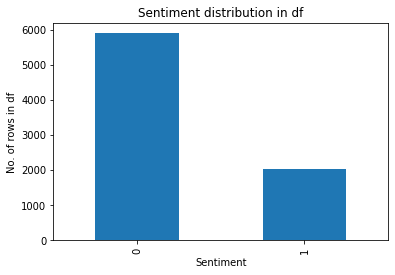

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.value_counts(df['label']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

There's class imbalance. Let's take 2000 from negative tweets and 2000 from positive tweets to balance the data.

In [6]:
df_negative = df[df['label']==1].head(n=2000)
df_positive = df[df['label']==0].head(n=2000)

df2 = pd.concat([df_negative, df_positive])
print(df2.shape)

(4000, 3)


In [7]:
df2 = df2.reset_index(drop=True)
df2.drop('id', axis=1, inplace=True)
df2.head()

,label,tweet
0,1,What amazing service! Apple won't even talk to...
1,1,iPhone software update fucked up my phone big ...
2,1,hey #apple when you make a new ipod dont make ...
3,1,Ha! Not heavy machinery but it does what I nee...
4,1,Contemplating giving in to the iPhone bandwago...


## Preprocess Text Data

In [8]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Tokenize and remove stopwords

In [9]:
df2['tweet'] = df2['tweet'].str.lower()

In [10]:
tweet_preprocessed = []
for tweet in df2['tweet']:
  review = re.sub('[^a-zA-Z0-9]', ' ', tweet)
  review = nltk.word_tokenize(review)
  review = [word for word in review if not word in set(stopwords.words('english'))]
  tweet_preprocessed.append(review)

df2['tweet_preprocessed'] = tweet_preprocessed
df2.head()

,label,tweet,tweet_preprocessed
0,1,what amazing service! apple won't even talk to...,"[amazing, service, apple, even, talk, question..."
1,1,iphone software update fucked up my phone big ...,"[iphone, software, update, fucked, phone, big,..."
2,1,hey #apple when you make a new ipod dont make ...,"[hey, apple, make, new, ipod, dont, make, new,..."
3,1,ha! not heavy machinery but it does what i nee...,"[ha, heavy, machinery, need, apple, really, dr..."
4,1,contemplating giving in to the iphone bandwago...,"[contemplating, giving, iphone, bandwagon, sim..."


### 2. Lemmatization/Stemming

I prefer Lemmatization

In [11]:
wordnet = WordNetLemmatizer()
df2['tweet_preprocessed'] = [[wordnet.lemmatize(word) for word in tokens] for tokens in df2['tweet_preprocessed']]
df2['tweet_preprocessed'].head()

0    [amazing, service, apple, even, talk, question...
1    [iphone, software, update, fucked, phone, big,...
2    [hey, apple, make, new, ipod, dont, make, new,...
3    [ha, heavy, machinery, need, apple, really, dr...
4    [contemplating, giving, iphone, bandwagon, sim...
Name: tweet_preprocessed, dtype: object

In [12]:
df2.loc[0, 'tweet_preprocessed']

['amazing',
 'service',
 'apple',
 'even',
 'talk',
 'question',
 'unless',
 'pay',
 '19',
 '95',
 'stupid',
 'support']

## Split into train and test sets

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2[['tweet', 'tweet_preprocessed']],
                                                    df2['label'],
                                                    shuffle = True,
                                                    test_size = 0.3,
                                                    random_state = 15)

print('Value counts for train sentiments:')
print(y_train.value_counts())
print('Value counts for test sentiments:')
print(y_test.value_counts())
print(type(X_train))
print(type(y_train))
X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.to_frame()
y_train = y_train.reset_index()
y_test = y_test.to_frame()
y_test = y_test.reset_index()
print(X_train.head())

Value counts for train sentiments:
1    1406
0    1394
Name: label, dtype: int64
Value counts for test sentiments:
0    606
1    594
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                 tweet_preprocessed
0   1095  ...  [apple, charger, suck, pleaserevinefollowandli...
1   1668  ...  [word, like, use, describe, stupid, mac, machi...
2   1407  ...             [lady, 0, 15, bidding, co, want, burn]
3    355  ...  [anguyoops, problem, 90, stuff, cd, vinyl, rel...
4   1634  ...  [nolanseibel, well, shouldnt, say, 8g, givemet...

[5 rows x 3 columns]


## Word2Vec model

In [14]:
from gensim.models import Word2Vec
import time

#CBOW model (sg = 0)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 0

word2vec_model_file = '/content/drive/My Drive/Colab Notebooks/100daysdl/word2vec_' + str(size) + '.model'
start_time = time.time()

stemmed_tokens = pd.Series(df2['tweet_preprocessed']).values

# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, 
                     min_count = min_count, 
                     size = size, 
                     workers = workers, 
                     window = window, 
                     sg = sg)

print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 4.369306802749634


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
import numpy as np

# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

# Unique ID of the word
print("Index of the word 'apple':")
print(sg_w2v_model.wv.vocab["apple"].index)

# Total number of the words 
print(len(sg_w2v_model.wv.vocab))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(sg_w2v_model['apple']))

# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
print(np.mean([sg_w2v_model[token] for token in df2['tweet_preprocessed'][0]], axis=0))


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Index of the word 'apple':
0
12305
Length of the vector generated for a word
1000
Print the length after taking average of all word vectors in a sentence:
[-3.49082388e-02  3.47874798e-02 -5.99069381e-03  2.97853481e-02
  1.79931223e-02  3.68579626e-02  3.19235921e-02  1.59107987e-02
  9.95803531e-03  2.42047235e-02  5.48702441e-02 -1.93147939e-02
 -1.16951168e-02  1.51226791e-02  1.41293174e-02  3.17835025e-02
 -3.20257172e-02  2.05971692e-02 -6.26275316e-02  2.54206583e-02
 -2.71290690e-02 -2.63290424e-02  1.60493720e-02  3.80013660e-02
 -2.91323643e-02  2.93657347e-03  1.57533605e-02  1.10064643e-02
  1.33720161e-02  1.53987454e-02 -1.16500733e-02 -2.02151556e-02
  1.09017640e-02  1.60738844e-02 -4.97092605e-02 -5.21196472e-03
 -3.40524712e-04 -2.17106175e-02  1.78714562e-02 -3.19883116e-02
  6.32661283e-02  2.28126366e-02  4.28277254e-02  2.65611559e-02
 -3.19743566e-02  3.70307304e-02 -3.41278017e-02  1.84610393e-02
  5.37689216e-03 -1.21806487e-02 -2.10880805e-02 -2.11198647e-02


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Next will see how to use the Word2Vec model to get the vector for documents in the dataset.

## Generating Word2Vec Vectors

In [16]:
# Store the vectors for train data in following file
word2vec_filename = '/content/drive/My Drive/Colab Notebooks/100daysdl/' + 'day34_train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
  for index, row in X_train.iterrows():
      model_vector = (np.mean([sg_w2v_model[token] for token in row['tweet_preprocessed']], axis=0)).tolist()
      if index == 0:
          header = ",".join(str(ele) for ele in range(12000))
          word2vec_file.write(header)
          word2vec_file.write("\n")
      
      # Check if the line exists else it is vector of zeros
      if type(model_vector) is list:  
          line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
      else:
          line1 = ",".join([str(0) for i in range(12000)])
      word2vec_file.write(line1)
      word2vec_file.write('\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


## Training Sentiment Classification using Word2Vec Vectors

In [17]:
import time
from sklearn.tree import DecisionTreeClassifier

# Load from the filename
word2vec_df = pd.read_csv(word2vec_filename)
word2vec_df = word2vec_df.fillna(0)

#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()

# Fit the model
clf_decision_word2vec.fit(word2vec_df, y_train['label'])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 3.8413970470428467


## Testing the model

In [18]:
from sklearn.metrics import classification_report

test_features_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['tweet_preprocessed']], axis=0)
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(12000)]))

test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)
print(classification_report(y_test['label'], test_predictions_word2vec))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       606
           1       0.49      1.00      0.66       594

    accuracy                           0.49      1200
   macro avg       0.25      0.50      0.33      1200
weighted avg       0.25      0.49      0.33      1200



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import f1_score

weighted_f1 = f1_score(y_test['label'], test_predictions_word2vec, average='weighted')
print(weighted_f1*100)

32.77926421404682
